## Imports

In [4]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models
import os
from utils import process_video_frames_tchw, count_predictions
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Directory Setup

In [6]:
# Root directory for dataset
ROOT_DIR = '../../data/BiteCount'
FOLDS_DIR = './folds/'  
VIDEO_DIR = os.path.join(ROOT_DIR, 'video')

# Checkpoint path
CHECKPOINT_DIR = '/media/sadat/sadat/resnet_benchmarks'
save_file = os.path.join(FOLDS_DIR, 'combined_results.csv')

#### Action Trigger Module Settings

In [3]:
ENTER_THRESHOLD = 0.78
EXIT_THRESHOLD = 0.4
MOMENTUM = 0.4

BATCH_SIZE = 64

#### Model initialization

In [4]:
# Initialize model and optimizer
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(device)

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Helper Function

In [5]:
def predict_video(row):
    """Returns prediction, mae, and obo"""
    video_path = os.path.join(VIDEO_DIR, row['name'])
    ground_truth = row['count']
    transformed_tchw_tensor = process_video_frames_tchw(video_path).to(device)
    sigmoid = nn.Sigmoid()
    batch_size = BATCH_SIZE

    Y = []

    model.eval() 
    with torch.no_grad(): 
        for i in range(0, len(transformed_tchw_tensor) + 1, batch_size):
            batch = transformed_tchw_tensor[i:i + batch_size].cuda() 
            output = model(batch)  
            y_batch = sigmoid(output).cpu().numpy()  
            Y.append(y_batch)  

    Y = np.concatenate(Y, axis=0)  
    Y = Y.squeeze()
    return count_predictions(Y, ground_truth, ENTER_THRESHOLD, EXIT_THRESHOLD, MOMENTUM)

### Results Record

In [7]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# Initialize an empty list to hold all results
all_results = []

for fold in range(1, 11):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'best_resnet152_fold{fold}.pth')
    model.load_state_dict(torch.load(checkpoint_path))

    test_annotation_file = os.path.join(FOLDS_DIR, f'test_fold_{fold}.csv')
    df = pd.read_csv(test_annotation_file)

    for index, row in df.iterrows():
        prediction, mae, obo = predict_video(row)
        # Append each result as a dictionary to the list
        all_results.append({
            'fold': fold,
            'name': row['name'],
            'ground_truth': row['count'],
            'prediction': prediction
        })

# Convert the results list to a DataFrame
all_results_df = pd.DataFrame(all_results)

# Save the combined results DataFrame to CSV
save_file = os.path.join(FOLDS_DIR, 'combined_results.csv')
all_results_df.to_csv(save_file, index=False)

# Calculate and print mean metrics for each fold if needed
for fold in range(1, 11):
    fold_results = all_results_df[all_results_df['fold'] == fold]
    oboas_mean = fold_results['obo'].mean() if 'obo' in fold_results.columns else None
    maes_mean = fold_results['mae'].mean() if 'mae' in fold_results.columns else None
    print(f"Fold {fold} - Mean OBO: {oboas_mean}, Mean MAE: {maes_mean}")


/tmp/ipykernel_1675375/3076327617.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
/tmp/ipykernel_1675375/3076327617.p

Fold 1 - Mean OBO: None, Mean MAE: None
Fold 2 - Mean OBO: None, Mean MAE: None
Fold 3 - Mean OBO: None, Mean MAE: None
Fold 4 - Mean OBO: None, Mean MAE: None
Fold 5 - Mean OBO: None, Mean MAE: None
Fold 6 - Mean OBO: None, Mean MAE: None
Fold 7 - Mean OBO: None, Mean MAE: None
Fold 8 - Mean OBO: None, Mean MAE: None
Fold 9 - Mean OBO: None, Mean MAE: None
Fold 10 - Mean OBO: None, Mean MAE: None


### Results

In [7]:
df = pd.read_csv(save_file)
df.head()

,fold,name,ground_truth,prediction
0,1,10f1a9b90589c2bc657320dc4958fb19ea2d51fbcdb251...,13,14
1,1,37c993d16e39c7a06469d11edce24326323c489f75de5d...,17,17
2,1,37c993d16e39c7a06469d11edce24326323c489f75de5d...,7,7
3,1,46e9cc048a75d3c6404323ffa5ff8668c6b96a1640c61a...,4,0
4,1,4ff8a74c52c529eceb817a1d89e76a3ae053583c2abc49...,10,10


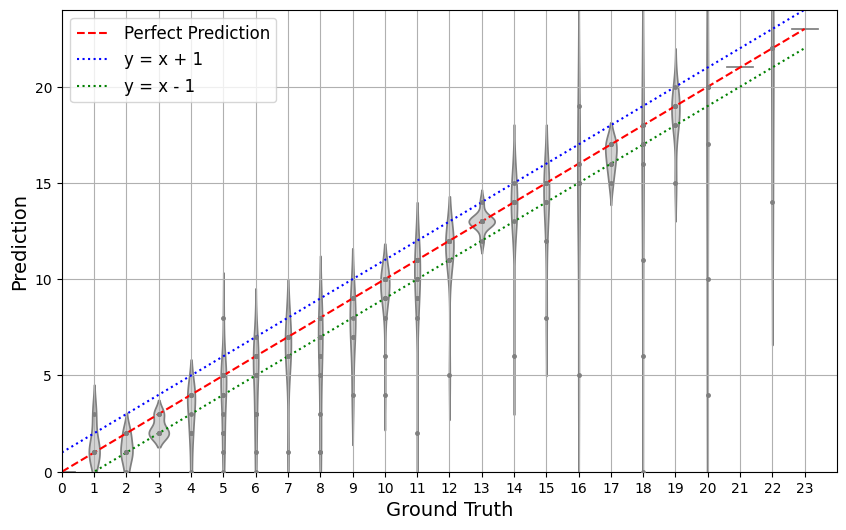

In [16]:
# Creating a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='ground_truth', y='prediction', inner='point', color='lightgray')

# Adding a line for perfect prediction
max_value = max(df['ground_truth'].max(), df['prediction'].max())
plt.plot([0, max_value], [0, max_value], linestyle='--', color='red', label='Perfect Prediction')

# Adding lines for y = x + 1 and y = x - 1
plt.plot([0, max_value], [1, max_value + 1], linestyle=':', color='blue', label='y = x + 1')
plt.plot([0, max_value], [-1, max_value - 1], linestyle=':', color='green', label='y = x - 1')

# Plot customizations
plt.xlabel('Ground Truth', fontsize=14)
plt.ylabel('Prediction', fontsize=14)
plt.xlim(0, max_value + 1)  # Adding some padding
plt.ylim(0, max_value + 1)  # Adding some padding
plt.legend(fontsize=12)
plt.grid()

# Save the plot without the title
plt.savefig('ground_truth_vs_prediction_violin_plot.png', bbox_inches='tight')
plt.show()